## Cats and Dogs 이진 분류

### 이진분류 프로젝트

#### 개요
- 목표 : CNN으로 개와 고양이 이미지 분류 이진 분류기

#### Kaggle 데이터 다운로드
- 캐글이 뭐에요?
    - https://www.kaggle.com/
    - 예측모델 및 분석 대회 플랫폼. 2017년 구글이 인수


1. Kaggle 계정 만들기
2. 설정 진입
    - https://www.kaggle.com/settings
    - API > Create New Token 클릭 kaggle.json 다운로드

3. 파이썬 Kaggle 패키지 설치
    ```shell
    !pip install kaggle
    ```

4. Kaggle json 파일
    - 리눅스/유닉스 : ~/.kaggle/kaggle.json
    - 윈도우 : %USERPROFILE%\.kaggle
        - 사용자 폴더 아래
    - 다운로드 받은 kaggle.json 붙여넣기

5. https://www.kaggle.com/competitions/dogs-vs-cats/overview 진입
    - Data탭에서 Join the competiton 버튼 클릭

In [1]:
!pip install kaggle

  Using cached bleach-6.2.0-py3-none-any.whl.metadata (30 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached webencodings-0.5.1-py2.py3-none-any.whl.metadata (2.1 kB)
   ---------------------------------------- 0.0/173.2 kB ? eta -:--:--
   ------------------------------------- -- 163.8/173.2 kB 5.0 MB/s eta 0:00:01
   ---------------------------------------- 173.2/173.2 kB 3.5 MB/s eta 0:00:00
Using cached bleach-6.2.0-py3-none-any.whl (163 kB)
   ---------------------------------------- 0.0/78.2 kB ? eta -:--:--
   ---------------------------------------- 78.2/78.2 kB 4.5 MB/s eta 0:00:00
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Using cached webencodings-0.5.1-py2.py3-none-any.whl (11 kB)



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# 데이터셋 다운로드
!kaggle competitions download -c dogs-vs-cats

#### 데이터셋 전처리

In [24]:
# 파이썬 모듈로드
import os, shutil, random

In [34]:
# 500개씩 샘플링 함수
def sample_data(src_dir, dst_dir, num_samples=500):
    os.makedirs(dst_dir, exist_ok=True)     # 폴더 생성, exist_ok=True 이미 존재하면 다시 만들지 않음
    all_files = [f for f in os.listdir(src_dir) if f.startswith(dst_dir.split('/')[-1])]
    samples = random.sample(all_files, num_samples)
    for f in samples:
        shutil.copy(os.path.join(src_dir, f), os.path.join(dst_dir, f))

In [ ]:
# 폴더 정리
base_dir = './data/train'   # 원본 폴더 25000개
cat_dir= './data/sample/cat'    # ./data/sample/cat/ -> 마지막에 / 추가하면 안됨
dog_dir= './data/sample/dog'

In [27]:
os.makedirs(cat_dir, exist_ok=True)
os.makedirs(dog_dir, exist_ok=True)

In [36]:
# sample_data() 함수 사용
sample_data(base_dir, cat_dir, 500)
sample_data(base_dir, dog_dir, 500)

<img src="../image/ml021.png" width=600>

#### 파이토치 시작

- ImageFolder 클래스 - 폴더명을 자동으로 레이블로 변환
    - cat -> 0, dog -> 1

In [40]:
# 파이토치 모듈 로드
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [41]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

In [42]:
train_dataset = ImageFolder('./data/sample', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

#### train_loader 시각화

In [43]:
# 시각화용 모듈 로드
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [44]:
from matplotlib import rcParams, font_manager, rc

font_path = 'C:/Windows/Fonts/malgun.ttf' 
font = font_manager.FontProperties(fname=font_path).get_name() 
rc('font', family=font) 
rcParams['axes.unicode_minus'] = False 

sns.set_style('darkgrid')
sns.set_theme(font='Malgun Gothic', rc={'axes.unicode_minus' : False}) 

In [45]:
# 배치하나 꺼내기
images, labels = next(iter(train_loader))

In [46]:
images[0].shape

torch.Size([3, 128, 128])

In [48]:
class_names = ['cat', 'dog']

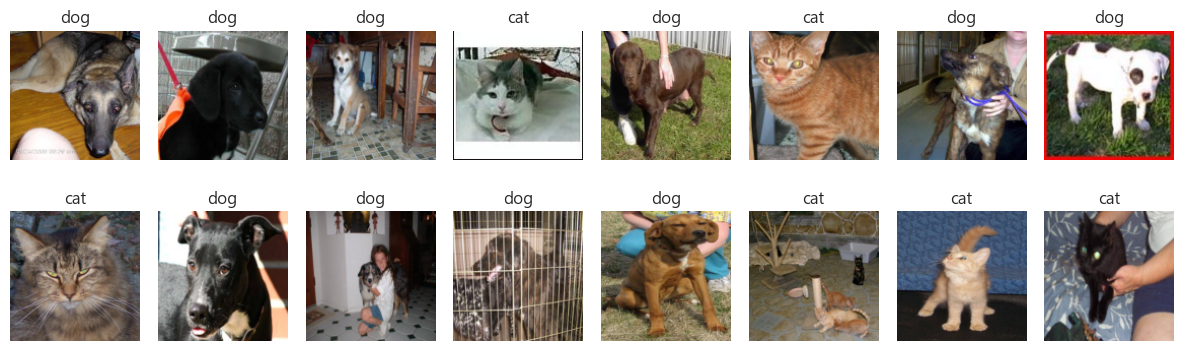

In [ ]:
# 시각화
plt.figure(figsize=(12, 4))
for i in range(16):     # 32개 중 반만 표현
    plt.subplot(2, 8, i+1)

    img = images[i].permute(1, 2, 0)    # 컬러채널이기 때문에 matplotlib 표현시 순서 변경
    plt.imshow(img)
    plt.title(f'{class_names[labels[i].item()]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

#### CNN 모델정의

In [60]:
# 사용모듈 로드
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# 클래스 정의
class CatDogCNN(nn.Module):
    def __init__(self):
        super(CatDogCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  # conv1, conv2 모두 사용
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)  # MaxPool(128) -> MaxPool(64) -> 32x32
        self.fc2 = nn.Linear(128, 1)    # 마지막 분류가 0, 1

    def forward(self, x):
        # conv -> activation -> maxpooling 이 과정을 2회 실시
        # dense1, 2 통과
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = x.view(-1, 64 * 32 * 32)         # flattern -> 1차원 배열화 65536개 입력

        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x

#### 훈련

In [62]:
# cuda 준비
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CatDogCNN().to(device)
criterion = nn.BCELoss()    # Binary Cross Entropy 손실함수
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [67]:
# 훈련함수 정의
def train(model, loader, criterion, optimizer):
    model.train()   # 훈련모드
    total_loss = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.float().to(device).unsqueeze(1)     # 1, 0 -> [1,], [0,]
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


In [68]:
# 훈련
EPOCH = 5
for epoch in range(EPOCH):
    loss = train(model, train_loader, criterion, optimizer )
    print(f'[{epoch+1}/{EPOCH}] Loss: {loss:.4f}')

RuntimeError: mat1 and mat2 shapes cannot be multiplied (65536x32 and 65536x128)